<a href="https://colab.research.google.com/github/flavioschneider/bachelorthesis/blob/master/GRU_noisy_regularization_path_firing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Path Code

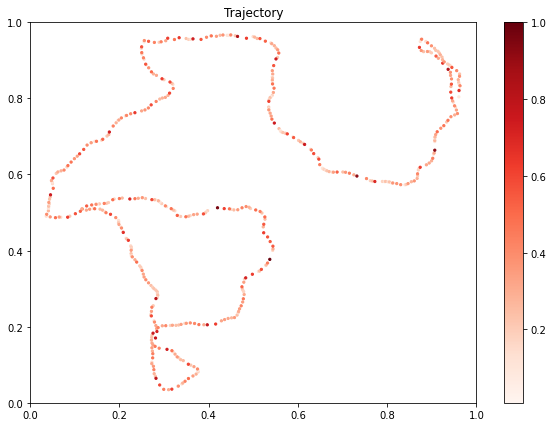

In [0]:
# Jupiter settings
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
!pip install livelossplot
# Haste 
"""
!apt install libeigen3-dev
!git clone https://github.com/lmnt-com/haste
!make -C haste
!pip install haste/haste_*.whl
"""

import math 
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

class PathSimulator():
    def __init__(self):
        self.dt=0.05
        self.maxGap=1-self.dt
        self.minGap=self.dt

        self.velScale = 0.13
        self.mAngVel = 0
        self.stddevAngVel = 330

        self.pos = np.random.uniform(low=self.minGap, high=self.maxGap, size=(2)) #np.random.uniform(low=self.minGap, high=self.maxGap, size=(2))
        self.facAng = np.random.uniform(low=-np.pi, high=np.pi)
        self.prevVel = 0

    def generateTrajectory(self, agent_steps=500, agent_new=False, room_size=1, room_walls=4, room_rotation=0):
        if agent_new:
            self.pos = np.random.uniform(low=self.minGap, high=self.maxGap, size=(2))
            self.facAng = np.random.uniform(low=-np.pi, high=np.pi)
            self.prevVel = 0

        velocities = np.zeros((agent_steps))
        angVel = np.zeros((agent_steps))
        positions = np.zeros((agent_steps, 2))
        angle = np.zeros((agent_steps))

        for t in range(agent_steps):
            # pick random rotational velocity from a normal distribution with 0 mean and stddevAngVel standard deviation
            rotVel = np.deg2rad(np.random.normal(
                self.mAngVel, self.stddevAngVel))
            # Check if the agent is near a wall
            if(self.checkWallAngle(self.facAng, self.pos, room_size, room_walls, room_rotation)):
                # if True, compute in which direction turning by 90 deg
                dAngle = self.computeRot(self.facAng, self.pos) + rotVel*self.dt
                # Velocity reduction factor
                vel = np.squeeze(self.prevVel - (self.prevVel*0.25))
            # If the agent is not near a wall, randomly sampling velocity and angVelocity
            else:
                # Sampling angular velocity
                dAngle = rotVel*self.dt
                # Sampling velocity
                vel = np.random.rayleigh(self.velScale)

            # Update the position of the agent
            newPos = self.pos + \
                (np.asarray([np.cos(self.facAng),
                             np.sin(self.facAng)])*vel)*self.dt

            # Update the facing angle of the agent
            newFacAng = (self.facAng + dAngle)
            # Keep the orientation between -np.pi and np.pi
            if(np.abs(newFacAng) >= (np.pi)):
                newFacAng = -1*np.sign(newFacAng) * \
                    (np.pi - (np.abs(newFacAng) - np.pi))

            velocities[t] = vel
            angVel[t] = rotVel
            positions[t] = self.pos
            angle[t] = self.facAng

            self.pos = newPos
            self.facAng = newFacAng
            self.prevVel = vel

        return velocities, angVel, positions, angle

    # HELPING FUNCTIONS
    def checkWallAngle(self, ang, pos, r_size, r_walls, r_rot):
        #print("Rat orientation:", ang)
        if((0 <= ang and ang <= (np.pi/2)) and np.any(pos > self.maxGap)):
            return True
        elif((ang >= (np.pi/2) and ang <= np.pi) and (pos[0] < self.minGap or pos[1] > self.maxGap)):
            return True
        elif((ang >= -np.pi and ang <= (-np.pi/2)) and np.any(pos < self.minGap)):
            return True
        elif((ang >= (-np.pi/2) and ang <= 0) and (pos[0] > self.maxGap or pos[1] < self.minGap)):
            return True
        else:
            return False

    def computeRot(self, ang, pos):
        rot = 0
        if(ang >= 0 and ang <= (np.pi/2)):
            if(pos[1] > self.maxGap):
                rot = -ang
            elif(pos[0] > self.maxGap):
                rot = np.pi/2-ang
        elif(ang >= (np.pi/2) and ang <= np.pi):
            if(pos[1] > self.maxGap):
                rot = np.pi-ang
            elif(pos[0] < self.minGap):
                rot = np.pi/2 - ang
        elif(ang >= -np.pi and ang <= (-np.pi/2)):
            if(pos[1] < self.minGap):
                rot = -np.pi - ang
            elif(pos[0] < self.minGap):
                rot = -(ang + np.pi/2)
        else:
            if(pos[1] < self.minGap):
                rot = -ang
            elif(pos[0] > self.maxGap):
                rot = (-np.pi/2) - ang

        return rot

def plot_paths(x, y, z, x_pred=[], y_pred=[], text="Trajectory"):
    fig = plt.figure(figsize=(10,7))
    fig.add_axes();
    ax = fig.add_subplot(111)
    ax.set_title(text)
    plt.xlim(0,1)
    plt.ylim(0,1)
    sc = ax.scatter(x, y, c=z, s=5, cmap='Reds', alpha=1)
    fig.colorbar(sc, ax=ax)
    sc = ax.scatter(x_pred, y_pred, s=5, alpha=1, color='blue')

simulator = PathSimulator()
velocities, angVel, positions, angle = simulator.generateTrajectory(500,agent_new=True)
plot_paths(positions[:,0], positions[:,1], velocities/velocities.max(axis=0))

class PathsDataset(torch.utils.data.Dataset):
    
    OUTPUT_DIM = 2
    INPUT_DIM = 3

    def __init__(self, samples=10000, length=500): 
        self.samples = samples
        self.length = length 
        self.start_data = np.zeros((samples, OUTPUT_DIM))        # The encoded initial positions.
        self.input_data = np.zeros((samples, length, INPUT_DIM))
        self.output_data = np.zeros((samples, length, OUTPUT_DIM))
        self.simulator = PathSimulator()

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        if self.start_data[idx, 0] == 0:
            v, _, pos, a = simulator.generateTrajectory(self.length+1, agent_new=True)
            self.start_data[idx] = pos[0]
            self.input_data[idx] = np.stack((v[:-1], np.cos(a[:-1]), np.sin(a[:-1])), axis=-1)
            self.output_data[idx] = pos[1:]
        return self.start_data[idx], self.input_data[idx], self.output_data[idx]
        

# Model

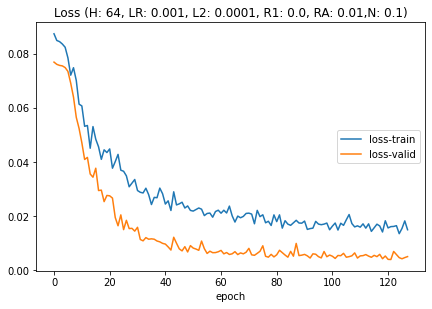

Loss (H: 64, LR: 0.001, L2: 0.0001, R1: 0.0, RA: 0.01,N: 0.1)
	loss-train       	 (min:    0.013, max:    0.087, cur:    0.015)
	loss-valid       	 (min:    0.004, max:    0.077, cur:    0.005)
Iter: 128/1000, Training Loss: 0.014893021434545517, Validation Loss: 0.00495559349656105


KeyboardInterrupt: ignored

In [0]:
SEQ_LENGTH = 500
NUM_TRAIN_SAMPLES = 2048
NUM_TEST_SAMPLES = 64
NUM_SAMPLES = NUM_TRAIN_SAMPLES+NUM_TEST_SAMPLES
BATCH_SIZE = 64

HIDDEN_DIM = 64
INPUT_DIM = 3
OUTPUT_DIM = 2

TORCH_MODEL = False
LOAD_SAVED_MODEL = False 
MODEL_PATH = './model.pt'
NUM_ITER = 1000
LR = 0.001
L2 = 0.0001
R1 = 0.0
RA = 0.01
RD = 0.0
NOISE = 0.1

class MGUCell(torch.jit.ScriptModule):

    def __init__(self, input_dim, hidden_dim): 
        super(MGUCell, self).__init__() 
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim 
        # tensor(cols, rows)
        self.W_if = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_hf = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_f  = nn.Parameter(torch.Tensor(hidden_dim,))
        self.W_in = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.b_in = nn.Parameter(torch.Tensor(hidden_dim,))  
        self.W_hn = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.init_parameters()
        
    def init_parameters(self): 
        std = 1.0 / math.sqrt(self.hidden_dim) 
        for w in self.parameters():
            init.uniform_(w, -std, std)

    # input = (batch_size, input_dim), hidden = (batch_size, hidden_dim)
    @torch.jit.script_method
    def forward(self, input, hidden):
        # This part could be made faster by more clever multiplications, i.e. less matrices. 
        f = torch.sigmoid(torch.mm(input, self.W_if) + torch.mm(hidden, self.W_hf) + self.b_f)
        n = torch.tanh(torch.mm(input, self.W_in) + self.b_in + torch.mm(f * hidden, self.W_hn))
        return f * hidden + (1 - f) * n


class GRUCell(torch.jit.ScriptModule):

    def __init__(self, input_dim, hidden_dim): 
        super(GRUCell, self).__init__() 
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim 
        self.W_ir = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_hr = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_r  = nn.Parameter(torch.Tensor(hidden_dim))
        self.W_iz = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_hz = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_z  = nn.Parameter(torch.Tensor(hidden_dim,))        
        self.W_in = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.b_in = nn.Parameter(torch.Tensor(hidden_dim,))          
        self.W_hn = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_hn = nn.Parameter(torch.Tensor(hidden_dim,))
        self.init_parameters()
        
    def init_parameters(self): 
        std = 1.0 / math.sqrt(self.hidden_dim) 
        for w in self.parameters():
            init.uniform_(w, std, std)

    @torch.jit.script_method
    def forward(self, input, hidden):
        r = torch.sigmoid(torch.mm(input, self.W_ir) + torch.mm(hidden, self.W_hr) + self.b_r)
        z = torch.sigmoid(torch.mm(input, self.W_iz) + torch.mm(hidden, self.W_hz) + self.b_z)
        n = torch.tanh(torch.mm(input, self.W_in) + self.b_in + r * (torch.mm(hidden, self.W_hn) + self.b_hn))
        return (1 - z) * n + z * hidden

class RecurrentModel(torch.jit.ScriptModule):

    def __init__(self, hidden_dim, input_dim, output_dim, dropout):
        super(RecurrentModel, self).__init__() 
        self.input_dim = input_dim     
        self.hidden_dim = hidden_dim 
        self.output_dim = output_dim 
        self.dropout = dropout 

        self.W_sh = nn.Parameter(torch.Tensor(output_dim, hidden_dim))
        self.b_sh = nn.Parameter(torch.zeros(hidden_dim,))  
        self.cell = nn.GRUCell(input_dim, hidden_dim)         
        self.W_ho = nn.Parameter(torch.Tensor(hidden_dim, output_dim))
        self.b_ho = nn.Parameter(torch.zeros(output_dim,))
        init.normal_(self.W_sh, 0, 0.1)
        init.normal_(self.W_ho, 0, 0.1)

    # input = (seq_length, batch_size, input_dim)
    # states = (seq_length, batch_size, hidden_dim)
    @torch.jit.script_method
    def forward(self, inputs, start, noise):
        seq_length = inputs.size(0)
        batch_size = inputs.size(1)
        hidden = torch.mm(start, self.W_sh) + self.b_sh
        states = torch.jit.annotate(List[Tensor], [])
        outputs = torch.jit.annotate(List[Tensor], [])
        for t in range(seq_length):
            hidden = self.cell(inputs[t], hidden)
            hidden = hidden + noise[t] 
            output = torch.mm(hidden, self.W_ho) + self.b_ho
            states += [hidden] 
            outputs += [output]
        return torch.stack(outputs), torch.stack(states) # stack: List of tensors to tensor

class RecurrentTorchModel(nn.Module):

    def __init__(self, hidden_dim, input_dim, output_dim, dropout):
        super(RecurrentTorchModel, self).__init__() 
        self.input_dim = input_dim     
        self.hidden_dim = hidden_dim 
        self.output_dim = output_dim   
        self.sh = nn.Linear(output_dim, hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.gru_layer = nn.GRU(input_size=input_dim, hidden_size=hidden_dim)
        self.lin_layer = nn.Linear(hidden_dim, output_dim)

    # input = (seq_length, batch_size, input_dim)
    # states = (seq_length, batch_size, hidden_dim)
    def forward(self, inputs, start, noise):
        hidden = self.sh(start).unsqueeze(0) 
        states, state = self.gru_layer(inputs, hidden) 
        outputs = self.lin_layer(states) 
        return outputs, states

dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if TORCH_MODEL:
    model = RecurrentTorchModel(HIDDEN_DIM, INPUT_DIM, OUTPUT_DIM, RD)
else:
    model = RecurrentModel(HIDDEN_DIM, INPUT_DIM, OUTPUT_DIM, RD) 

model.to(dev)

if LOAD_SAVED_MODEL:
    model.load_state_dict(torch.load(MODEL_PATH))

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

dataset = PathsDataset(NUM_SAMPLES, SEQ_LENGTH)
train_set, val_set = torch.utils.data.random_split(
    dataset, 
    [NUM_TRAIN_SAMPLES, NUM_TEST_SAMPLES]
)

train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_set, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

groups = {'Loss (H: %s, LR: %s, L2: %s, R1: %s, RA: %s,N: %s)'%(HIDDEN_DIM,LR,L2,R1,RA,NOISE): ['loss-train', 'loss-valid']}
plotlosses = PlotLosses(groups=groups)

for iter in range(NUM_ITER):
    loss_train = None 
    loss_valid = None 

    for idx, (start, inputs, outputs) in enumerate(train_loader):
        start = start.float().to(dev)
        inputs = inputs.permute([1,0,2]).float().to(dev)
        outputs = outputs.permute([1,0,2]).float().to(dev)
        noise = torch.Tensor(SEQ_LENGTH, BATCH_SIZE, HIDDEN_DIM).normal_(0, NOISE).float().to(dev)
        optimizer.zero_grad()
        y_pred, states = model(inputs, start, noise)
        loss_train = criterion(y_pred, outputs)
        loss_train += R1 * ((torch.sum(torch.abs(states))) / (SEQ_LENGTH * BATCH_SIZE * HIDDEN_DIM))
        loss_train += RA * ((torch.norm(states)**2) / (SEQ_LENGTH * BATCH_SIZE * HIDDEN_DIM))   # Penalize high activation of hidden units. 
        loss_train.backward()
        optimizer.step() 

    for idx, (start, inputs, outputs) in enumerate(val_loader):
        start = start.float().to(dev)
        inputs = inputs.float().permute([1,0,2]).to(dev)
        outputs = outputs.float().permute([1,0,2]).to(dev)
        noise = torch.zeros((SEQ_LENGTH, BATCH_SIZE, HIDDEN_DIM)).float().to(dev)
        y_pred, states = model(inputs, start, noise)
        loss_valid = criterion(y_pred, outputs)

    if iter % 5 == 0:
        torch.save(model.state_dict(), MODEL_PATH)

    plotlosses.update({'loss-train': loss_train.item(), 'loss-valid': loss_valid.item()})
    plotlosses.send()
    print('Iter: %s/%s, Training Loss: %s, Validation Loss: %s' % (iter+1, NUM_ITER, loss_train.item(), loss_valid.item()))

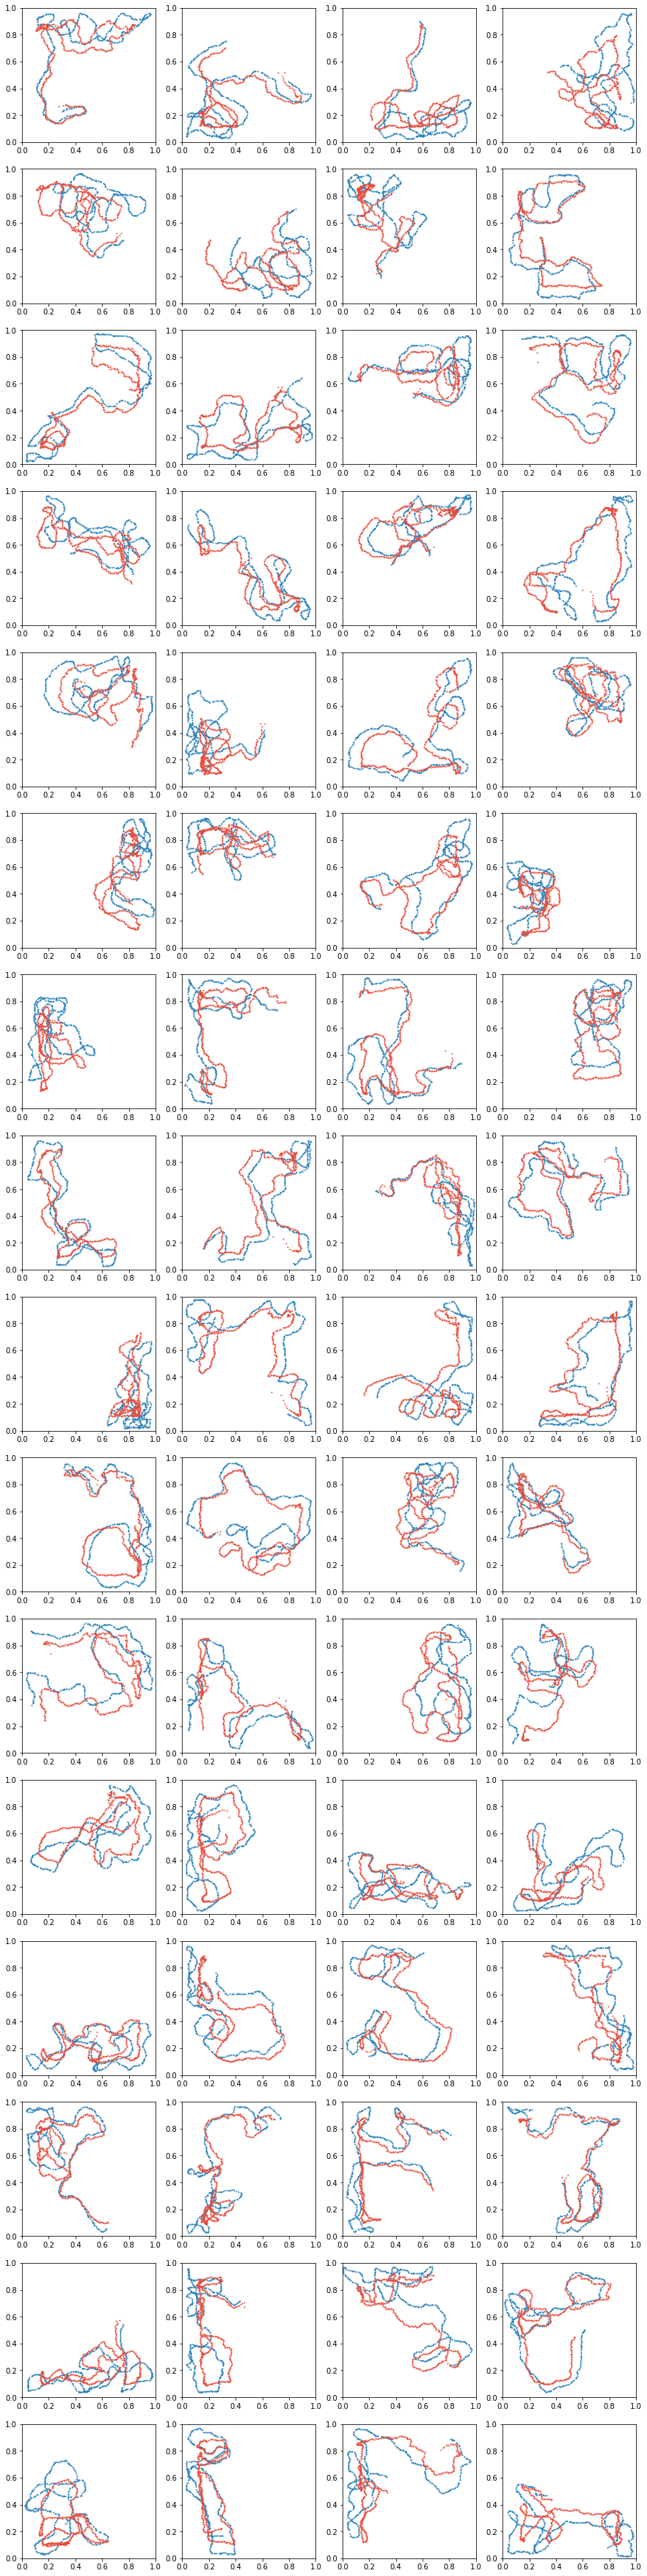

In [0]:
# Fit on test data 
model.eval()
noise = torch.zeros((SEQ_LENGTH, BATCH_SIZE, HIDDEN_DIM))
y_hat, y_out = None, None  

for idx, (start, inputs, outputs) in enumerate(val_loader):
    start = start.float().to(dev)
    inputs = inputs.float().permute([1,0,2]).to(dev)
    outputs = outputs.float().permute([1,0,2]).to(dev)
    noise = torch.zeros((SEQ_LENGTH, BATCH_SIZE, HIDDEN_DIM)).float().to(dev)
    y_pred, _ = model(inputs, start, noise)
    loss_valid = criterion(y_pred, outputs)                 # Feed to model. 
    y_hat = y_pred 
    y_out = outputs


y_out = y_out.detach().cpu().numpy()
y_hat = y_hat.detach().cpu().numpy()

columns = 16
fig, axs = plt.subplots(columns, 4, figsize=(15, 4*columns))
i = 0
for ax in axs.flat:
    x_real = y_out[:,i,0]
    y_real = y_out[:,i,1]
    x_pred = y_hat[:,i,0]
    y_pred = y_hat[:,i,1]
    ax.scatter(x_real, y_real, s=1, color="#2980b9")
    ax.scatter(x_pred, y_pred, s=1,  color='#e74c3c')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    i+=1

Evaluationg model...
Evaluating activation rates...
Unit 1/64
Unit 2/64
Unit 3/64
Unit 4/64
Unit 5/64
Unit 6/64
Unit 7/64
Unit 8/64
Unit 9/64
Unit 10/64
Unit 11/64
Unit 12/64
Unit 13/64
Unit 14/64
Unit 15/64
Unit 16/64
Unit 17/64
Unit 18/64
Unit 19/64
Unit 20/64
Unit 21/64
Unit 22/64
Unit 23/64
Unit 24/64
Unit 25/64
Unit 26/64
Unit 27/64
Unit 28/64
Unit 29/64
Unit 30/64
Unit 31/64
Unit 32/64
Unit 33/64
Unit 34/64
Unit 35/64
Unit 36/64
Unit 37/64
Unit 38/64
Unit 39/64
Unit 40/64
Unit 41/64
Unit 42/64
Unit 43/64
Unit 44/64
Unit 45/64
Unit 46/64
Unit 47/64
Unit 48/64
Unit 49/64
Unit 50/64
Unit 51/64
Unit 52/64
Unit 53/64
Unit 54/64
Unit 55/64
Unit 56/64
Unit 57/64
Unit 58/64
Unit 59/64
Unit 60/64
Unit 61/64
Unit 62/64
Unit 63/64
Unit 64/64
Normalizing...
Plotting...


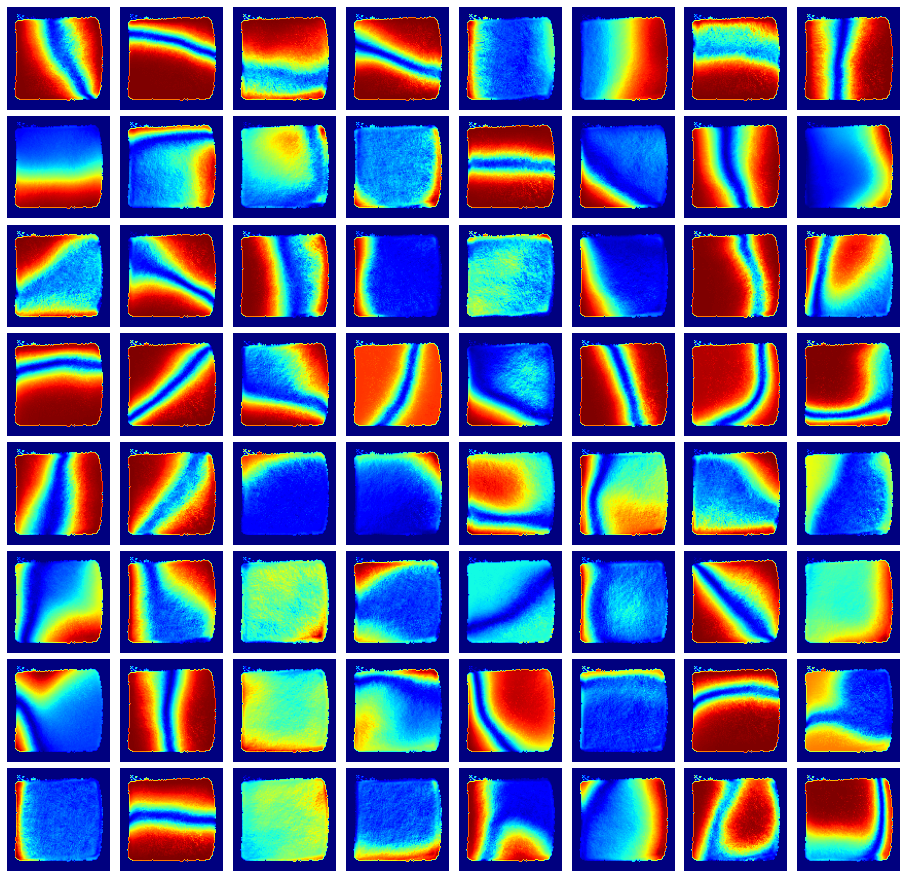

In [0]:
# Check activations of hidden units
ACT_NUM_SAMPLES = 500
ACT_SEQ_LENGTH = 500
ACT_RESOLUTION = 100

act_dataset = PathsDataset(ACT_NUM_SAMPLES, ACT_SEQ_LENGTH)
act_loader = torch.utils.data.DataLoader(act_dataset, batch_size=ACT_NUM_SAMPLES)

for idx, (start, inputs, outputsx) in enumerate(act_loader):
    start = start.float().to(dev)
    inputs = inputs.float().permute([1,0,2]).to(dev)
    outputsx = outputsx.float().permute([1,0,2]).to(dev)
    noise = torch.zeros((SEQ_LENGTH, ACT_NUM_SAMPLES, HIDDEN_DIM)).to(dev)
    outputs, states = model(inputs, start, noise)


print("Evaluationg model...")
outputs = np.concatenate(outputs.detach().cpu().numpy()) 
states = np.concatenate(states.detach().cpu().numpy())

rate = np.zeros([HIDDEN_DIM, ACT_RESOLUTION, ACT_RESOLUTION])
count = np.zeros([ACT_RESOLUTION, ACT_RESOLUTION])

print("Evaluating activation rates...")
for unit in range(HIDDEN_DIM):
    for step in range(ACT_NUM_SAMPLES*ACT_SEQ_LENGTH):
        x = outputs[step, 0] * ACT_RESOLUTION 
        y = outputs[step, 1] * ACT_RESOLUTION 
        if(int(x) >= ACT_RESOLUTION or int(y) >= ACT_RESOLUTION): continue 
        count[int(x), int(y)] += 1
        rate[unit, int(x), int(y)] += np.abs(states[step, unit]) # is abs right?
    print("Unit %s/%s"%(unit+1, HIDDEN_DIM))

print("Normalizing...")     
for x in range(ACT_RESOLUTION):
    for y in range(ACT_RESOLUTION):
        if count[x, y] > 0:
            rate[:, x, y] /= count[x, y]

print("Plotting...")
columns = HIDDEN_DIM // 8
fig, axs = plt.subplots(columns, 8, figsize=(16, 2*columns))
i = 0
for ax in axs.flat:
    ax.imshow(rate[i,:,:] / np.max(rate[i,:,:]), cmap="jet")
    ax.axis('off')
    ax.set_aspect('equal')
    i+=1

fig.subplots_adjust(wspace=0.1, hspace=0)


In [0]:
import matplotlib.pyplot as plt
inner_products = np.zeros((HIDDEN_DIM, HIDDEN_DIM)) 

for i in range(HIDDEN_DIM):
    for j in range(HIDDEN_DIM): 
        inner_products[i,j] = np.trace(np.matmul(rate[i].T, rate[j]))

plt.figure(figsize=(8, 5))
plt.hist(inner_products.diagonal(), bins=20, color='#2980b9', label='Value', rwidth=0.8)
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(inner_products[~np.eye(inner_products.shape[0], dtype=bool)], bins=20, color='#2980b9', label='Value', rwidth=0.8)
plt.show()